#Домашнее задание №2

Источник данных:
https://www.kaggle.com/andrewmvd/animal-faces

(Для загрузки необходима регистрация на kaggle, в верхней части страницы кнопка download для загрузки архива. Альтернативно - загрузка через kaggle api напрямую в colab: https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb )

- Необходимо реализовать систему классификации лиц животных. Задача представляет из себя классификацию на 3 класса. 
- Необходимо загрузить изображения и привести их к единому формату. Важно понимать, что исходное разрешение очень больше, и простые сети на несколько слоев могут выдать не такое хорошее качество. 
- Необходимо обучить нейросеть для распознавания 3 классов, желательно будет сравнить результаты на нескольких параметрах.
- Оценить по метрикам качества для каждого класса.
- Важно визуализировать результат прогноза (на тесте) в человеко-читаемом формате с подписью.

На отлично:
- Aугментация изображений.
- Файнтюнинг крупной сверточной сети.

Подсказки:
Как найти файлы в папках: https://pythoner.name/walk
Как загрузить изображение по пути:
from PIL import Image
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

img = np.asarray(Image.open(path_to_image))
plt.imshow(img_to_array(img))

***

Присылать дз можно как ссылкой на колаб (предпочтительнее) так и ноутбуком. Альтернативно - гит/кеггл, где в описании аккаунта указаны ваши инициалы.

Ваши решения присылать ссылкой на ноутбук на почту mlsber.fall21@gmail.com (с пометкой "Про" в теме письма)

ВАЖНО:
* В шапке укажите ваше ФИО и номер задания.
* Когда выбираете "поделиться" в колабе нажимайте "изменить" и выставляйте "доступные пользователям у которых есть ссылка" - иначе у нас нет прав на просмотр вашего решения.

###Полезные ссылки:

https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212

###1. Загрузить данные

In [70]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [71]:
%%capture
!unzip /drive/MyDrive/ml/dl_course_2022/02/archive.zip -d /content

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision import transforms
from sklearn.metrics import f1_score, recall_score, precision_score

###Dataset

In [73]:
import os

In [74]:
from tqdm import tqdm

In [75]:
train_path = '/content/afhq/train'
test_path = '/content/afhq/val'

In [76]:
def get_img_paths(data_path):
    data = []
    for path, folder, files in os.walk(data_path):
        if files:
            for f in tqdm(files):
                data.append(path + '/' + f)
    return data

train = get_img_paths(train_path)
test = get_img_paths(test_path)

100%|██████████| 500/500 [00:00<00:00, 853541.72it/s]


###Привести изображения к единому формату

In [77]:
labels_dict = {
    'wild': 0,
    'cat': 1,
    'dog': 2
}

In [78]:
class CustomDataset(Dataset):
    
    def __init__(self, images, labels_dict):
        self.images = images
        self.labels_dict = labels_dict
        
    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels_dict[image_path.split('/')[-2]]
        image = Image.open(image_path)
        image = image.resize((64, 64))
        image = transforms.ToTensor()(image)
        image = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image)
        return image, label
        
    def __len__ (self):
        return len(self.images)

In [79]:
train_dataset = CustomDataset(train, labels_dict)
test_dataset = CustomDataset(test, labels_dict)

In [80]:
BATCH_SIZE = 64

In [81]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

###Модель

In [82]:
class SimleConvNet(torch.nn.Module):

	
    def __init__(self):
        super(SimleConvNet, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [83]:
model = SimleConvNet()

In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [85]:
model.to(device)

SimleConvNet(
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

###Обучить нейросеть

In [86]:
loss_fn = torch.nn.CrossEntropyLoss()

In [87]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [108]:
def train(model, data_loader):
        model.train()
        for data in tqdm(data_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

In [109]:
def eval(model, data_loader):
    predicted = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data in tqdm(data_loader):
            x, y = data
            x = x.to(device)

            outputs = model(x)
            _, predict = torch.max(outputs.data, 1)
            predict = predict.cpu().detach().numpy().tolist()
            predicted += predict
            labels += y
        print(f1_score(labels, predicted, average=None))
    return labels, predicted

In [90]:
for epoch in range(5):
    train(model, train_loader)
    eval(model, test_loader)

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]


[0.87378641 0.89620758 0.87396694]


100%|██████████| 24/24 [00:10<00:00,  2.36it/s]


[0.88311688 0.90257353 0.91902834]


100%|██████████| 24/24 [00:10<00:00,  2.27it/s]


[0.91078838 0.93678161 0.92741935]


100%|██████████| 24/24 [00:10<00:00,  2.28it/s]


[0.93737374 0.94898941 0.9330587 ]


100%|██████████| 24/24 [00:10<00:00,  2.26it/s]

[0.93539055 0.95967742 0.9392379 ]


In [91]:
# 0.93539055 0.95967742 0.9392379

###Cравнить результаты на нескольких параметрах

In [ ]:
# Xavier init

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [94]:
model = SimleConvNet()

model.apply(init_weights)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

for epoch in range(5):
    train(model, train_loader)
    eval(model, test_loader)

100%|██████████| 24/24 [00:10<00:00,  2.31it/s]


[0.89570552 0.91615542 0.89463602]


100%|██████████| 24/24 [00:10<00:00,  2.33it/s]


[0.92291667 0.93014354 0.93266332]


100%|██████████| 24/24 [00:10<00:00,  2.35it/s]


[0.91823899 0.92553191 0.8915009 ]


100%|██████████| 24/24 [00:11<00:00,  2.14it/s]


[0.9373814  0.96424923 0.93898656]


100%|██████████| 24/24 [00:09<00:00,  2.52it/s]


[0.95912263 0.96593186 0.95495495]


In [ ]:
# 0.95912263 0.96593186 0.95495495

In [97]:
# add dropout

class SimleConvNet2(torch.nn.Module):

	
    def __init__(self):
        super(SimleConvNet2, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.1)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [98]:
model = SimleConvNet2()

model.apply(init_weights)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

for epoch in range(5):
    train(model, train_loader)
    eval(model, test_loader)

100%|██████████| 24/24 [00:09<00:00,  2.51it/s]


[0.89804325 0.90427699 0.88061127]


100%|██████████| 24/24 [00:09<00:00,  2.54it/s]


[0.92198582 0.93561368 0.91265947]


100%|██████████| 24/24 [00:09<00:00,  2.51it/s]


[0.94037146 0.94471387 0.92389006]


100%|██████████| 24/24 [00:10<00:00,  2.25it/s]


[0.95256917 0.96138211 0.94422311]


100%|██████████| 24/24 [00:09<00:00,  2.49it/s]


[0.94641052 0.9612711  0.94223108]


In [ ]:
# 0.94641052 0.9612711  0.94223108

In [99]:
# batchnorm

class SimleConvNet3(torch.nn.Module):

	
    def __init__(self):
        super(SimleConvNet3, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.1)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
        self.batchnorm1 = nn.BatchNorm1d(120)
        self.batchnorm2 = nn.BatchNorm1d(84)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [100]:
model = SimleConvNet3()

model.apply(init_weights)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

for epoch in range(5):
    train(model, train_loader)
    eval(model, test_loader)

100%|██████████| 24/24 [00:10<00:00,  2.28it/s]


[0.89914163 0.93933464 0.91586998]


100%|██████████| 24/24 [00:09<00:00,  2.52it/s]


[0.93065327 0.93658537 0.9244898 ]


100%|██████████| 24/24 [00:11<00:00,  2.06it/s]


[0.90440387 0.88314005 0.9092827 ]


100%|██████████| 24/24 [00:09<00:00,  2.40it/s]


[0.93647541 0.94980695 0.93724696]


100%|██████████| 24/24 [00:09<00:00,  2.58it/s]


[0.93762994 0.95975855 0.93869732]


###Aугментация изображений

In [101]:
class CustomDatasetAug(Dataset):
    
    def __init__(self, images, labels_dict):
        self.images = images
        self.labels_dict = labels_dict
        
    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels_dict[image_path.split('/')[-2]]
        image = Image.open(image_path)
        image = image.resize((80, 80))
        image = transforms.RandomCrop(64)(image)
        image = transforms.RandomHorizontalFlip()(image)
        image = transforms.ToTensor()(image)
        image = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image)
        return image, label
        
    def __len__ (self):
        return len(self.images)

In [110]:
train_data = get_img_paths(train_path)
test_data = get_img_paths(test_path)

100%|██████████| 500/500 [00:00<00:00, 1217151.48it/s]


In [111]:
train_dataset = CustomDatasetAug(train_data, labels_dict)
test_dataset = CustomDatasetAug(test_data, labels_dict)

In [112]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [113]:
model = SimleConvNet3()

model.apply(init_weights)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

for epoch in range(5):
    train(model, train_loader)
    eval(model, test_loader)

100%|██████████| 24/24 [00:10<00:00,  2.33it/s]


[0.84512428 0.86635071 0.81868743]


100%|██████████| 24/24 [00:09<00:00,  2.41it/s]


[0.89452333 0.91778203 0.88016529]


100%|██████████| 24/24 [00:09<00:00,  2.41it/s]


[0.89611752 0.90704225 0.91242363]


100%|██████████| 24/24 [00:09<00:00,  2.42it/s]


[0.93456033 0.959285   0.93596059]


100%|██████████| 24/24 [00:09<00:00,  2.40it/s]


[0.93639208 0.9496124  0.93161546]


###Оценить по метрикам качества для каждого класса 

In [ ]:
labels, predicted = eval(model, test_loader)

In [115]:
print(f1_score(labels, predicted, average=None))

[0.91553702 0.93924783 0.91434263]


In [121]:
print(recall_score(labels, predicted, average=None))

[0.878 0.974 0.918]


In [118]:
print(precision_score(labels, predicted, average=None))

[0.95642702 0.90689013 0.91071429]


###Визуализировать результат прогноза в человеко-читаемом формате с подписью

In [135]:
dataiter = iter(test_loader)

In [136]:
images, labels = dataiter.next()

In [137]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # convert to numpy objects
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

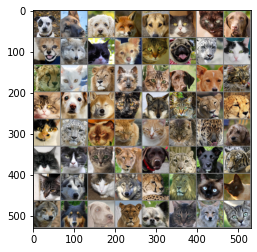

In [138]:
imshow(torchvision.utils.make_grid(images))

In [139]:
model.eval()
with torch.no_grad():
    x, y = images, labels
    x = x.to(device)

    outputs = model(x)
    _, predict = torch.max(outputs.data, 1)
    predict = predict.cpu().detach().numpy().tolist()

In [142]:
ans_list = [list(labels_dict.keys())[list(labels_dict.values()).index(i)] for i in predict]
ground_truth = [list(labels_dict.keys())[list(labels_dict.values()).index(i)] for i in labels]

print(ans_list)
print(ground_truth)

['dog', 'dog', 'dog', 'wild', 'dog', 'cat', 'cat', 'dog', 'wild', 'wild', 'cat', 'dog', 'cat', 'dog', 'wild', 'cat', 'wild', 'cat', 'wild', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'wild', 'cat', 'cat', 'wild', 'wild', 'cat', 'wild', 'cat', 'cat', 'cat', 'cat', 'wild', 'dog', 'cat', 'cat', 'cat', 'wild', 'dog', 'wild', 'dog', 'wild', 'cat', 'dog', 'cat', 'wild', 'wild', 'wild', 'cat', 'dog', 'wild', 'dog', 'cat', 'wild', 'dog', 'cat', 'wild', 'cat']
['dog', 'dog', 'dog', 'wild', 'dog', 'cat', 'cat', 'dog', 'wild', 'wild', 'cat', 'dog', 'cat', 'dog', 'wild', 'cat', 'wild', 'cat', 'wild', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'wild', 'cat', 'wild', 'wild', 'cat', 'wild', 'cat', 'cat', 'cat', 'cat', 'wild', 'dog', 'cat', 'cat', 'cat', 'wild', 'dog', 'wild', 'dog', 'wild', 'cat', 'dog', 'cat', 'wild', 'wild', 'wild', 'cat', 'cat', 'wild', 'dog', 'dog', 'wild', 'dog', 'cat', 'wild', 'cat']


###Файнтюнинг крупной сверточной сети

In [143]:
from torchvision import models

In [144]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [150]:
num_ftrs = model.fc.in_features

In [151]:
model.fc = nn.Linear(num_ftrs, 3)

In [153]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [154]:
class CustomDataset2(Dataset):
    
    def __init__(self, images, labels_dict):
        self.images = images
        self.labels_dict = labels_dict
        
    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels_dict[image_path.split('/')[-2]]
        image = Image.open(image_path)
        image = image.resize((224, 224))
        image = transforms.ToTensor()(image)
        image = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image)
        return image, label
        
    def __len__ (self):
        return len(self.images)

In [155]:
train_data = get_img_paths(train_path)
test_data = get_img_paths(test_path)

100%|██████████| 500/500 [00:00<00:00, 1358259.07it/s]


In [156]:
train_dataset = CustomDatasetAug(train_data, labels_dict)
test_dataset = CustomDatasetAug(test_data, labels_dict)

In [157]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [158]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

for epoch in range(5):
    train(model, train_loader)
    eval(model, test_loader)

100%|██████████| 24/24 [00:10<00:00,  2.24it/s]


[0.988 0.992 0.988]


100%|██████████| 24/24 [00:10<00:00,  2.25it/s]


[0.9743083  0.99297894 0.97880928]


100%|██████████| 24/24 [00:10<00:00,  2.27it/s]


[0.98495486 0.99099099 0.98207171]


100%|██████████| 24/24 [00:10<00:00,  2.24it/s]


[0.98178138 0.99201597 0.98415842]


100%|██████████| 24/24 [00:10<00:00,  2.25it/s]

[0.98281092 0.99499499 0.98616601]


In [159]:
labels, predicted = eval(model, test_loader)

100%|██████████| 24/24 [00:10<00:00,  2.25it/s]

[0.98380567 0.99099099 0.9851925 ]


In [160]:
print(f1_score(labels, predicted, average=None))

[0.98380567 0.99099099 0.9851925 ]


In [161]:
print(recall_score(labels, predicted, average=None))

[0.972 0.99  0.998]


In [162]:
print(precision_score(labels, predicted, average=None))

[0.99590164 0.99198397 0.97270955]
